<a href="https://colab.research.google.com/github/jumafernandez/imbalanced_data/blob/main/notebooks/estrategia_propia_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recuperación de instancias no sintéticas (BERT)

__Autor:__ Juan Manuel Fernandez

__Objetivo:__ En esta notebook se evalúa una estrategia de balanceo de instancias propia basada en la recuperación de instancias no sintéticas como estrategia para el balanceo de clases para problemas de clasificación automática de textos.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

Y las utilizadas para la representación de documentos.

In [4]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import representacion_documentos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [5]:
import warnings
from os import path
import pandas as pd
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'

etiquetas = get_clases()

# Chequeo sobre si los archivos están en el working directory
if not(path.exists(TRAIN_FILE)):
  # Genero el enlace completo
  URL_file_train = DS_DIR + TRAIN_FILE
  URL_file_test = DS_DIR + TEST_FILE
  # Descargo los archivos
  import wget
  wget.download(URL_file_train)
  wget.download(URL_file_test)
  
# Leemos el archivo en un dataframe
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

print(f"\nEl conjunto de entrenamiento tiene la dimensión: {len(df_train)}.")
print(f"El conjunto de testeo tiene la dimensión: {len(df_test)}.")

df_train = df_train[['consulta', 'clase']]


El conjunto de entrenamiento tiene la dimensión: 800.
El conjunto de testeo tiene la dimensión: 200.


### Incorporación de las instancias no sintéticas para el balanceo de carga

Se incorporan las instancias no sintéticas recuperadas de Elasticsearch para las estrategias de *feature selection* (SS3  $U$ TF-IDF).

En primer lugar se carga el dataset con 200 instancias por clase recuperadas con boosting:

In [6]:
DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/03-elasticsearch/sin_procesar/'

FILE_ss3 = 'dataset-ss3-200-boosting.csv'
FILE_tfidf = 'dataset-tfidf-200-boosting.csv'

if not(path.exists(FILE_ss3)) or not(path.exists(FILE_tfidf)):
  # Genero el enlace completo
  URL_file_ss3 = DIR + FILE_ss3
  URL_file_tfidf = DIR + FILE_tfidf
  # Descargo los archivos
  import wget
  wget.download(URL_file_ss3)
  wget.download(URL_file_tfidf)

# Leemos los archivos en un dataframe
df_ss3 = pd.read_csv(FILE_ss3)
df_tfidf = pd.read_csv(FILE_tfidf)

df_ss3 = df_ss3[['consulta', 'score', 'clase']]
df_tfidf = df_tfidf[['consulta', 'score', 'clase']]

# Preprocesamos las consultas
df_ss3['consulta'] = pd.Series(preprocesar_correos(df_ss3['consulta']))
df_tfidf['consulta'] = pd.Series(preprocesar_correos(df_tfidf['consulta']))

# Verifico que no haya instancias con faltantes y si hay las borro
df_ss3 = df_ss3.dropna()
df_tfidf = df_tfidf.dropna()

print(f"\nEl conjunto de datos SS3 posee {len(df_ss3)} instancias.")
print(f"El conjunto de datos TF-IDF posee {len(df_tfidf)} instancias.")


El conjunto de datos SS3 posee 3200 instancias.
El conjunto de datos TF-IDF posee 3200 instancias.


Ahora joineamos las instancias de cada estrategia que coinciden y hacemos el promedio de los scores para cada estrategia:

In [7]:
# Transformo un df a una lista de diccionarios
ss3_list = df_ss3.to_dict('records')

# Y el otro en 3 listas (una con la consulta, otra con el score y otra con la clase)
tf_consulta = list(df_tfidf['consulta'])
tf_clase = list(df_tfidf['clase'])
tf_score = list(df_tfidf['score'])

In [8]:
join_consultas = pd.DataFrame(columns = ['consulta', 'score', 'clase'])
                    
for r in ss3_list:
  if (r['consulta'] in tf_consulta) and (r['clase'] == tf_clase[tf_consulta.index(r['consulta'])]):
    
    # Me guardo un df con la consulta y el score promedio
    score_avg = (r['score'] + tf_score[tf_consulta.index(r['consulta'])])/2
    aux = {'consulta': r['consulta'], 'score': score_avg, 'clase': r['clase']}
        
    join_consultas = join_consultas.append(aux, ignore_index=True)

Obtenemos la siguiente cantidad de instancias no sintéticas por clase:

In [9]:
cantidad_balanceo = join_consultas.groupby(['clase'])['clase'].count()

cantidad_balanceo

clase
Boleto Universitario                    74
Cambio de Carrera                       68
Cambio de Comisión                      95
Consulta por Equivalencias              38
Consulta por Legajo                     84
Consulta sobre Título Universitario     68
Cursadas                                28
Datos Personales                        54
Exámenes                                82
Ingreso a la Universidad                71
Pedido de Certificados                 137
Problemas con la Clave                 124
Reincorporación                         21
Requisitos de Ingreso                  147
Simultaneidad de Carreras               70
Situación Académica                     47
Name: clase, dtype: int64

Ordeno las instancias no sintéticas por clase y score (descendente):

In [10]:
join_consultas = join_consultas.sort_values(['clase','score'], ascending=False)

join_consultas

,consulta,score,clase
1162,buenos dias comunico situacion academica respe...,26.721049,Situación Académica
1163,buenas tardes curse gimnasia formativa 34004 p...,25.319655,Situación Académica
1161,buenos dias duda respecto situacion academica ...,24.868055,Situación Académica
1164,hola 16 mayo rendi final taller lectura compre...,22.607658,Situación Académica
1190,buenos dias quisiera saber figura finales cond...,22.222622,Situación Académica
...,...,...,...
67,buenas tardes quisiera realizar consulta respe...,22.612747,Boleto Universitario
73,buenos dias cuatrimestre pasado inscribi bolet...,22.587778,Boleto Universitario
70,buen dia boleto estudiantil hace varios meses ...,22.451445,Boleto Universitario
63,hice tramite boleto estudiantil hace meses tod...,22.184043,Boleto Universitario


#### Incorporación al conjunto de datos original de las instancias no sintéticas

En primer lugar, evalúo la cantidad de instancias por clase que tengo en el dataset de entrenamiento:

In [11]:
instancias_por_clase = df_train.groupby(['clase'])['clase'].count()

max_instancias = df_train.groupby(['clase'])['clase'].count().max()

instancias_por_clase

clase
Boleto Universitario                   193
Cambio de Carrera                       11
Cambio de Comisión                       8
Consulta por Equivalencias              10
Consulta por Legajo                     15
Consulta sobre Título Universitario     10
Cursadas                                75
Datos Personales                         6
Exámenes                                18
Ingreso a la Universidad               135
Pedido de Certificados                  59
Problemas con la Clave                  91
Reincorporación                         43
Requisitos de Ingreso                   98
Simultaneidad de Carreras                6
Situación Académica                     22
Name: clase, dtype: int64

In [12]:
X_train = []
y_train = []

for clase in etiquetas:
  # Calculo la cantidad de instancias a agregar según la necesidad y disponibilidad
  cantidad = min(max_instancias - instancias_por_clase[clase], cantidad_balanceo[clase])
  # Las selecciono
  instancias_clase = join_consultas.loc[join_consultas['clase'] == clase][['consulta', 'clase']].head(cantidad)

  # Las agrego
  df_train = df_train.append(instancias_clase, ignore_index=True)
  print(f'{clase}: {cantidad}')

Boleto Universitario: 0
Cambio de Carrera: 68
Cambio de Comisión: 95
Consulta por Equivalencias: 38
Consulta por Legajo: 84
Consulta sobre Título Universitario: 68
Cursadas: 28
Datos Personales: 54
Exámenes: 82
Ingreso a la Universidad: 58
Pedido de Certificados: 134
Problemas con la Clave: 102
Reincorporación: 21
Requisitos de Ingreso: 95
Simultaneidad de Carreras: 70
Situación Académica: 47


Verifico la cantidad de instancias finales por clase:

In [13]:
distribucion_clases_final = df_train.groupby(['clase'])['clase'].count()

In [14]:
# Calculo la media
media = int(distribucion_clases_final.mean())
print(f'La media de instancias es {media}.')

MEDIA = False

if MEDIA:
  # Tomo la media de instancias como máximo
  df_train = df_train.sort_values(['clase']).groupby('clase').head(media).reset_index(drop=True)  

La media de instancias es 115.


Grafico la serie resultante con el balanceo:

			Distribución de clases para el Total dataset


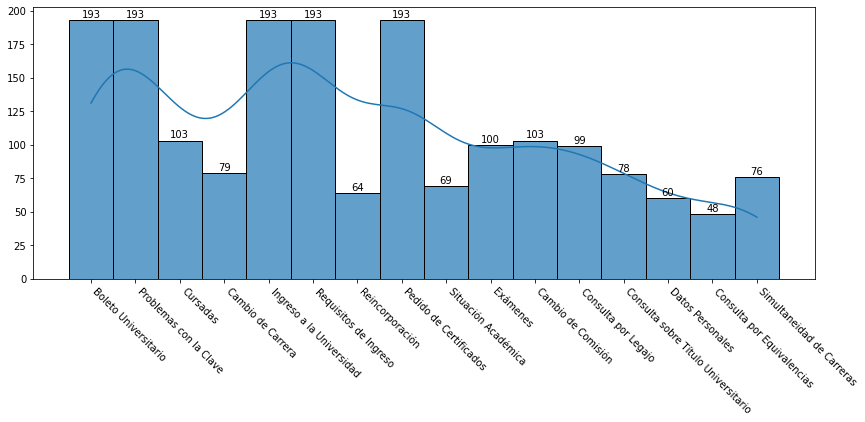

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def hist_clases(serie_clases, desc_plot, filename_plot):
  """
  Se plotean las clases en función de la distribución de la frecuencia
  observada en cada dataset
  """

  # Set figure size
  plt.figure(figsize=(14,5))

  ax = sns.histplot(serie_clases, kde=True, stat='count', 
                    bins=serie_clases.unique(), binwidth=0.06, 
                    palette="viridis", alpha=0.7)

  ax.set_xticklabels(serie_clases.unique(),
                    rotation=-45, 
                    horizontalalignment='left', fontweight='light')

  for p in ax.patches:
      ax.annotate(f'{p.get_height():.0f}\n',
                  (p.get_x() + p.get_width() / 2, p.get_height()), 
                  ha='center', va='center', color='black')

  # Quito el nombre de los ejes (de forma rústica)
  plt.xlabel('', fontsize=12)
  plt.ylabel('', fontsize=12)

  # Guardo el plot en un png
  plt.savefig(filename_plot, optimize=True, transparent=True, bbox_inches = 'tight')

  # Muestro el gráfico con una descripción
  print(f'\t\t\tDistribución de clases para el {desc_plot}')
  plt.show()  

hist_clases(df_train['clase'], 'Total dataset', 'histograma_total.png')

Se prepan los conjuntos de datos para entrenar BERT (requiere nombres y cantidad de _features_ particulares):

In [16]:
train_df = df_train[['consulta', 'clase']]
train_df.columns = ['text', 'labels']
test_df = df_test[['consulta', 'clase']]
test_df.columns = ['text', 'labels']

## Elección de un modelo monolenguaje pre-entrenado

La librería *simpletransformers* se basa en la librería *Transformers* de HuggingFace. Esto permite utilizar todos los modelos pre-entrenados disponibles en la [Transformers library](https://huggingface.co/transformers/pretrained_models.html) que son provistos por toda la comunidad de desarrolladores. Para ver cuales son los modelos disponibles, se puede ingresar a [https://huggingface.co/models](https://huggingface.co/models).

En nuestro caso, vamos a utilizar el modelo `dccuchile/bert-base-spanish-wwm-cased`. Este modelo está pre-entrenado por un equipo de investigadores del Departamento de Computación de la Universidad de Chile.

### Definición del Modelo para Clasificación

Se carga el modelo pre-entrenado BETO con la respectiva definición de hiperparámetros para el entrenamiento:

In [17]:
from simpletransformers.classification import ClassificationModel

CANTIDAD_CLASES = len(etiquetas)

# Cantidad de epochs
epocas = 4

# Hiperparámetros
train_args = {
        'overwrite_output_dir': True,
        'num_train_epochs': epocas,
        'fp16': True,
        'learning_rate': 4e-5,
        'do_lower_case': True,
        'use_early_stopping': True,
        }

# Creamos el ClassificationModel
model = ClassificationModel(
    model_type='bert', 
#    model_name='bert-base-multilingual-cased',
    model_name='dccuchile/bert-base-spanish-wwm-cased',
    num_labels=CANTIDAD_CLASES,
    use_cuda=False,
    args=train_args
)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Se verifican los parámetros del modelo:

In [18]:
model.args

ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=True, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=4e-05, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, 

## Entrenamiento

Se entrena el modelo con el dataset de train en función de los hiperparámetros.

En primer lugar, se encodean las etiquetas:

In [19]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_df.labels)
train_df.labels = le.transform(train_df.labels)

In [20]:
ENTRENA_NUEVO_MODELO=True

if ENTRENA_NUEVO_MODELO:
  # Entrenamos el modelo
  model.train_model(train_df)

  0%|          | 0/1844 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/231 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/231 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/231 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/231 [00:00<?, ?it/s]

## Testeo del modelo entrenado

Se testea el modelo sobre el 20% de instancias reservadas para esta tarea:

In [21]:
# Ejecutamos las predicciones sobre testing
predictions, raw_outputs = model.predict(list(test_df.text))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [22]:
predictions = le.inverse_transform(predictions)

predictions

array(['Boleto Universitario', 'Problemas con la Clave',
       'Cambio de Carrera', 'Situación Académica',
       'Problemas con la Clave', 'Boleto Universitario',
       'Ingreso a la Universidad', 'Consulta sobre Título Universitario',
       'Cursadas', 'Problemas con la Clave', 'Cursadas',
       'Ingreso a la Universidad', 'Problemas con la Clave', 'Exámenes',
       'Requisitos de Ingreso', 'Ingreso a la Universidad',
       'Cambio de Carrera', 'Pedido de Certificados',
       'Pedido de Certificados', 'Reincorporación', 'Cursadas',
       'Cursadas', 'Requisitos de Ingreso', 'Reincorporación',
       'Consulta por Equivalencias', 'Boleto Universitario', 'Exámenes',
       'Problemas con la Clave', 'Problemas con la Clave',
       'Requisitos de Ingreso', 'Problemas con la Clave',
       'Pedido de Certificados', 'Ingreso a la Universidad',
       'Requisitos de Ingreso', 'Simultaneidad de Carreras',
       'Requisitos de Ingreso', 'Requisitos de Ingreso',
       'Requisitos de

In [23]:
# Evaluamos el modelo
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Calculo las métricas sobre test para el paper
acc_test = accuracy_score(test_df.labels, predictions)
precision_test = precision_score(test_df.labels, predictions, average='weighted')
recall_test = recall_score(test_df.labels, predictions, average='weighted')
f1_test = f1_score(test_df.labels, predictions, average='weighted')
mcc_test = matthews_corrcoef(test_df.labels, predictions)

# Genero un diccionario con los parámetro y el acc en test
dict_test = {}
dict_test['clasificador'] = 'BETO'
dict_test['accuracy'] = acc_test
dict_test['precision'] = precision_test
dict_test['recall'] = recall_test
dict_test['f1_score'] = f1_test
dict_test['mcc'] = mcc_test
 
# Paso el diccionario a dataframe y lo guardo en un archivo con fecha/hora
results_test = pd.DataFrame([dict_test])
print(results_test)

  clasificador  accuracy  precision  recall  f1_score       mcc
0         BETO     0.865   0.878693   0.865  0.865741  0.845766


In [24]:
mcc_test

0.8457661820516162

Se guardan los resultados en un archivo csv:

In [25]:
# Lo guardo en un archivo
from datetime import datetime

now = datetime.now()
nombre_results_test = 'results_test.csv'

results_test.to_csv(nombre_results_test, mode='w')

### Matriz de confusión del modelo

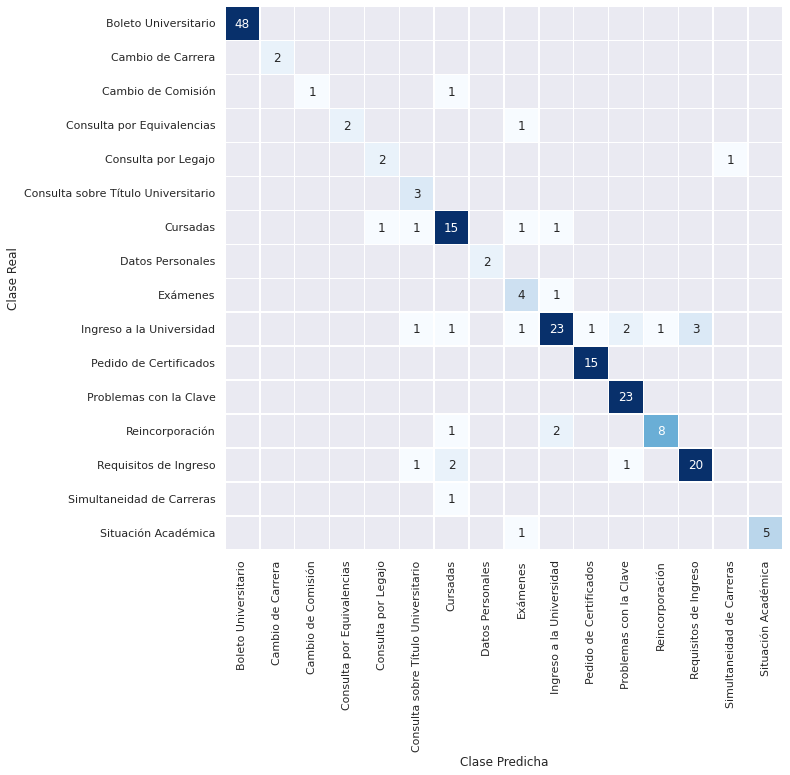

In [26]:
import numpy as np
from sklearn import metrics #Importar el módulo metrics de scikit-learn
import seaborn as sns
import matplotlib.pyplot as plt

matriz_confusion = metrics.confusion_matrix(test_df.labels, predictions)

sns.set()
my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
for i in range(matriz_confusion.shape[0]):
    for j in range(matriz_confusion.shape[0]):
        my_mask[i][j] = matriz_confusion[i][j] == 0 
  
fig_dims = (10, 10)
plt.subplots(figsize=fig_dims)

ax = sns.heatmap(matriz_confusion,
                 xticklabels=etiquetas,
                 annot=True, 
                 fmt="d", 
                 linewidths=.5, 
                 cmap="Blues", 
                 cbar=False, 
                 mask=my_mask, 
                 vmax=15)

plt.gcf().set_size_inches(10, 10)
plt.xticks(rotation=90, ha="center")
plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real');

plt.show()

# Referencias
- https://towardsdatascience.com/bert-text-classification-in-a-different-language-6af54930f9cb
- https://medium.com/dair-ai/beto-spanish-bert-420e4860d2c6